/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_37893/4287200098.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

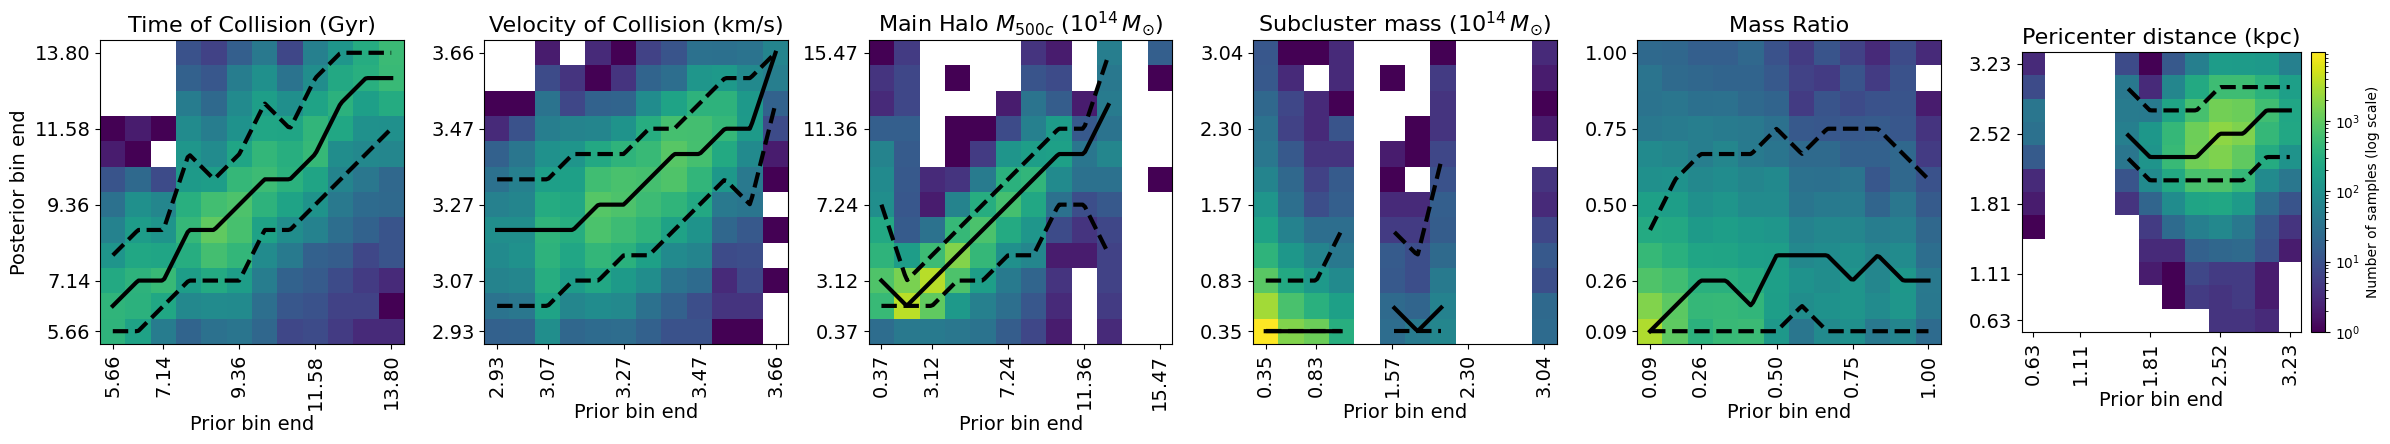

In [20]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import cINN

TARGET_COLS = [
    'Time of Collision (Gyr)',
    'Velocity of Collision (km/s)',
    r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
    r'Subcluster mass ($10^{14} \, M_{\odot}$)',
    'Mass Ratio',
    'Pericenter distance (kpc)',

]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    with viridis colormap, smooth & thicker median/percentile lines,
    and sparse ticks.
    """
    # --- Load data & model ---
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _    = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx         = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # --- Gather heatmap data for each target ---
    all_data = []
    results  = []
    for d in range(D_tar):
        gt   = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)

        # collect posterior samples per prior-bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.zeros(num_bins)
        lo_i   = np.zeros(num_bins)
        hi_i   = np.zeros(num_bins)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # --- Shared LogNorm across all heatmaps ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # --- Plot row of subplots + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    # sparse tick positions
    max_ticks = 5
    tick_positions = np.linspace(0, num_bins - 1,
                                 min(max_ticks, num_bins)).astype(int)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # smooth & thicker median line
        x_bins    = np.arange(num_bins)
        x_smooth  = np.linspace(0, num_bins - 1, num_bins * 10)
        med_smooth = np.interp(x_smooth, x_bins, med_i)
        lo_smooth  = np.interp(x_smooth, x_bins, lo_i)
        hi_smooth  = np.interp(x_smooth, x_bins, hi_i)

        ax.plot(x_smooth, med_smooth,  linestyle='-', linewidth=3, color='black')
        ax.plot(x_smooth, lo_smooth,   linestyle='--', linewidth=3, color='black')
        ax.plot(x_smooth, hi_smooth,   linestyle='--', linewidth=3, color='black')

        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel('Prior bin end', fontsize=14)
        if d == 0:
            ax.set_ylabel('Posterior bin end', fontsize=14)

        # apply sparse ticks
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           rotation=90, fontsize=14)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           fontsize=14)

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()

    # save figure as pdf and png
    #fig.savefig("2.prediction_performance1.pdf", bbox_inches='tight')
    fig.savefig("2.prediction_performance1.png", bbox_inches='tight')
    plt.show()

    return results


if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=100,
        random_state=42,
        num_bins=12
    )


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_37893/2327810567.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

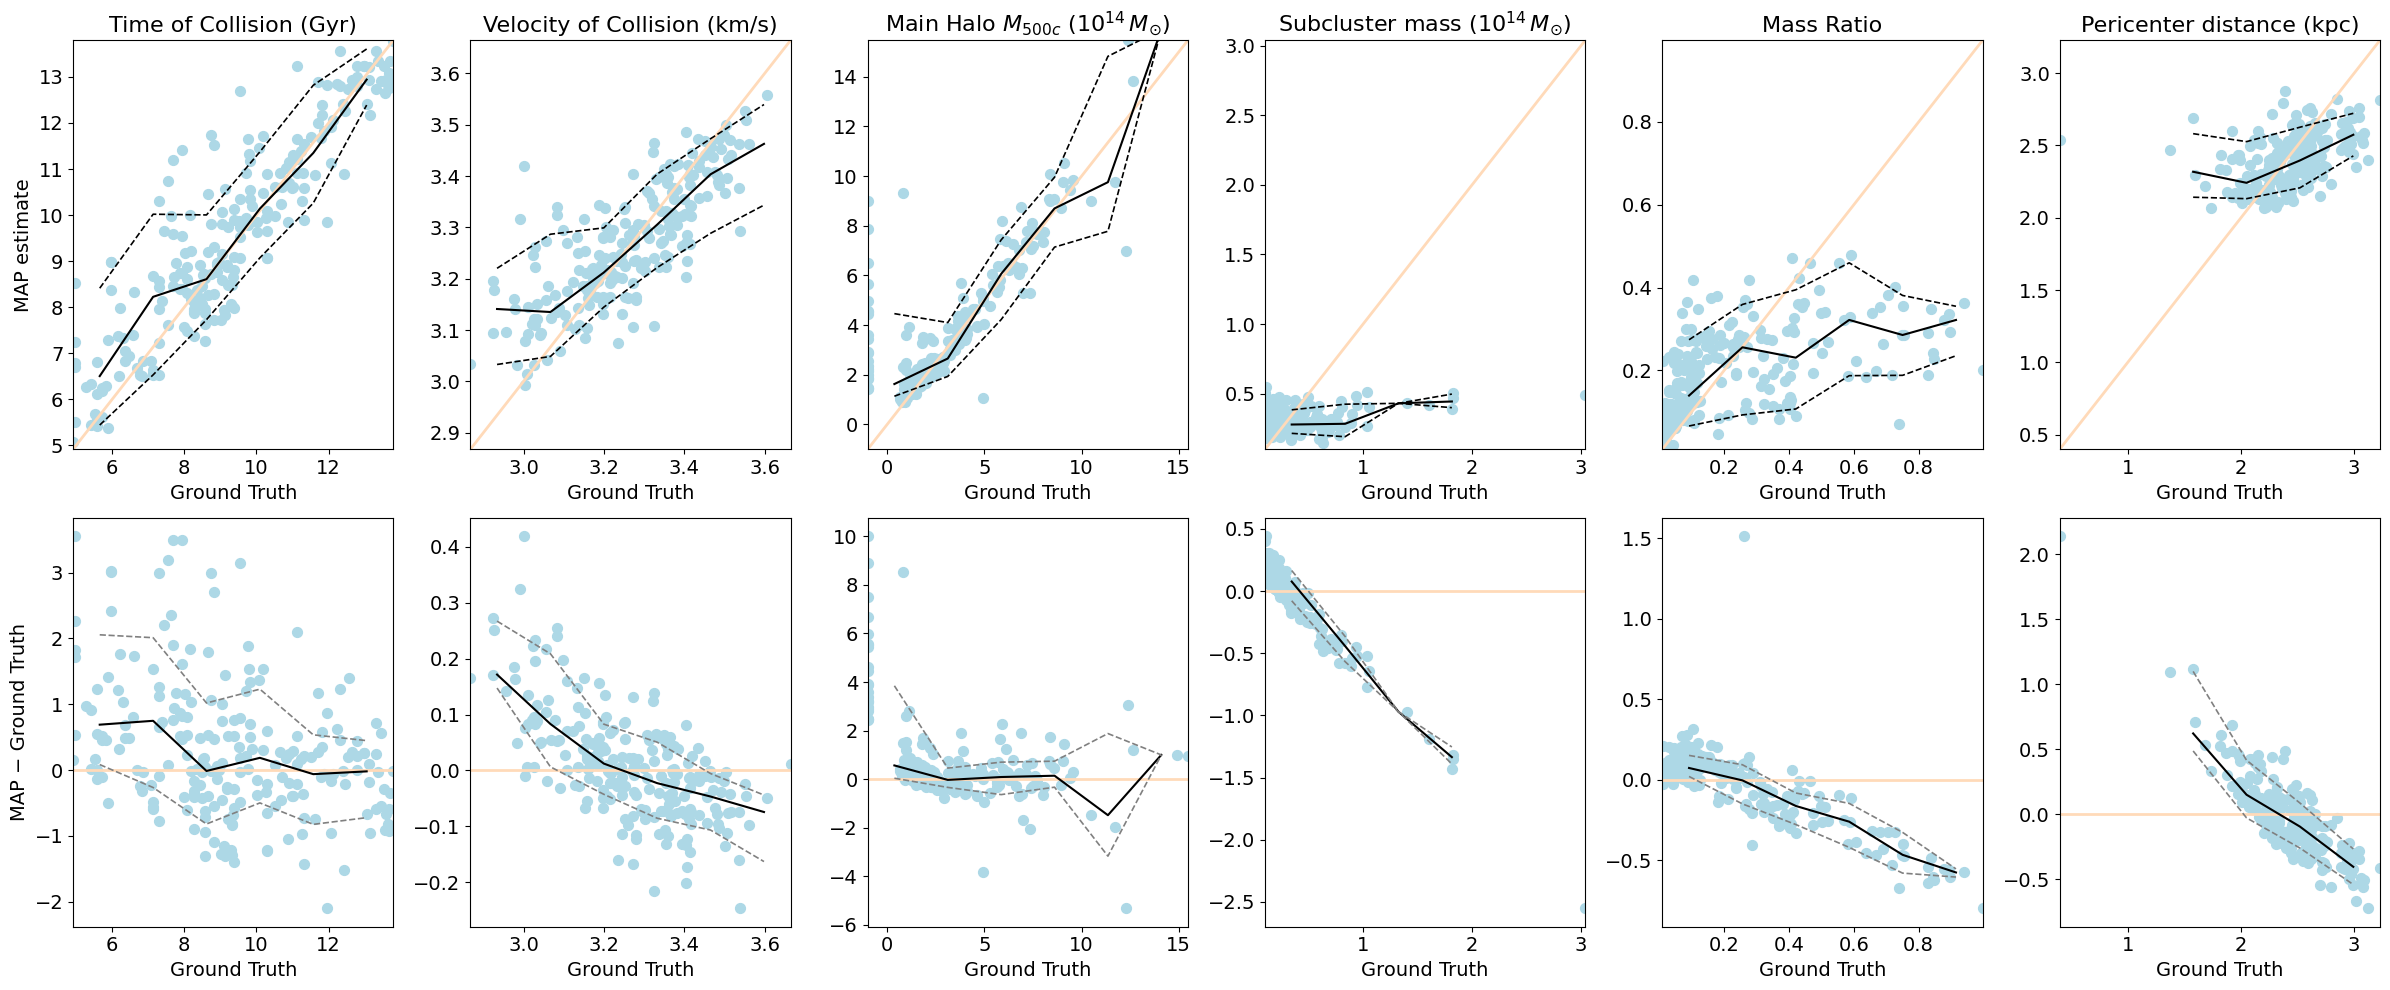

In [21]:
from sklearn.neighbors import KernelDensity

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    random_state: int = 42,
    label_fontsize: int = 14,
    title_fontsize: int = 16
):
    """
    Top row:    truth vs MAP (linear y), with percentile bands
    Bottom row: truth vs error (symlog y), with percentile bands
    Both rows:  scatter + bin‐wise medians (solid) & percentiles (dashed).
    X‐limits locked to [min(truth), max(truth)] for each target.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) set up figure: 2 rows × D_tar columns
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    # loop over targets
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        error = mapv - truth

        # common x‐limits from truth
        tmin, tmax = truth.min(), truth.max()

        # ==== Top: truth vs MAP ====
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=50, alpha=1.0, color='lightblue')
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        # bin and compute percentiles for MAP
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1

        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = mapv[inds == i_bin]
            if sel.size > 0:
                med_map[i_bin] = np.median(sel)
                lo_map[i_bin], hi_map[i_bin] = np.percentile(sel, [10, 90])

        ax.plot(centers, med_map, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo_map,  '--', linewidth=1.2, color='black')
        ax.plot(centers, hi_map,  '--', linewidth=1.2, color='black')

        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)
        ax.set_title(TARGET_COLS[d], fontsize=title_fontsize)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

        # ==== Bottom: truth vs error ====
        ax = axes[1, d]
        ax.scatter(truth, error, s=50, alpha=1., color = 'lightblue')
        ax.axhline(0, color='peachpuff', linewidth=2)

        # bin and compute percentiles for error
        med_err = np.full(num_bins, np.nan)
        lo1_err = np.full(num_bins, np.nan)
        hi1_err = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med_err[i_bin]  = np.median(sel)
                lo1_err[i_bin], hi1_err[i_bin] = np.percentile(sel, [16, 84])

        ax.plot(centers, med_err, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo1_err, '--', linewidth=1.2, color='gray')
        ax.plot(centers, hi1_err, '--', linewidth=1.2, color='gray')


        ax.set_xlim(tmin, tmax)

        ax.set_title("", fontsize=title_fontsize)  # no title on bottom
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP − Ground Truth", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

    # save figure as pdf and png
    #fig.savefig("2.prediction_performance2.pdf", bbox_inches='tight')
    fig.savefig("2.prediction_performance2.png", bbox_inches='tight')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_and_error_vs_truth(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=6,
        random_state=42
    )


